# Overview

This notebook imports Woodstock formatted input data files and optimize the harvest scheduling considering even flow constrainsts and other constraints. 

In [1]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
from util import compile_scenario, plot_scenario, cmp_c_z, cmp_c_cflw, cmp_c_caa, cmp_c_ci, gen_scenario, run_scenario
import gurobipy as grb

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age =  1000
tvy_name = 'totvol'
max_harvest = 1

In [6]:
fm = ws3.forest.ForestModel(model_name='equitysilver',
                            model_path='./data/woodstock_model_files_equitysilver',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

At this point, we have a simple but fully functional ws3 model instance. 

In [7]:
fm.reset()

Here is the age distribution for the AOI

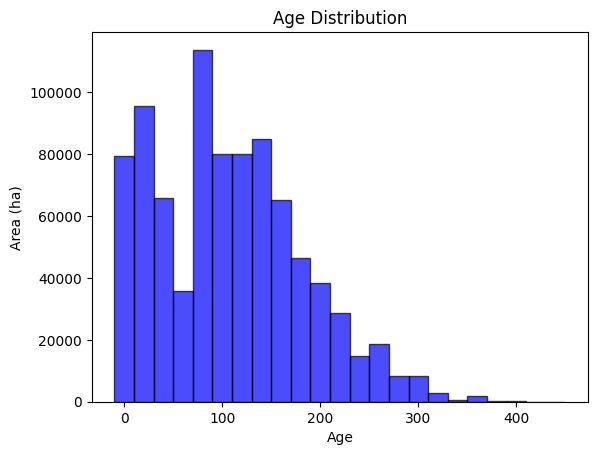

In [8]:
data = fm.age_class_distribution(0)
x_values = list(data.keys())
y_values = list(data.values()) 
bin_edges = np.arange(0, 480, 20)
hist, _ = np.histogram(x_values, bins=bin_edges, weights=y_values)
plt.bar(bin_edges[:-1], hist, width=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Area (ha)')
plt.title('Age Distribution')
plt.show()

## Implement optimization-based action scheduling

`ws3` also includes functions to automate the process of formulating and solving linear programming (LP) optimization problems to schedule actions in your model. Using an optimization approach, you formulate your forest-level management problem in terms of an _objective function_ and _constraints_.

`ws3` currently includes functions to formulate and solve Model I type optimization problems, as first documented in Johson and Scheurman (1977).

>Johnson, K.N. and H.L. Scheurman (1977). “Techniques for prescribing optimal
timber harvest and investment under different objectives—discussion and
synthesis”. In: Forest Science Monograph 23.suppl_1.



You will need to have `gurobipy` installed for this next step to work. At some point I will finish implementing bindings to the PuLP open-source solver library, but for now we are stuck with Gurobi as the only solver that works with ws3. 

You should be able to install `gurobipy` using the magic `%pip` command below, however this _only_ installs the Python module and minimal solver binaries. This _does not_ install the full Gurobi software stack, do the Gurobi licence managent tools (including the `grbgetkey` command) are _not_ installed automatically with the Python module. The `gurobipy` installation includes a limited software license that should allow you to solve _small_ problem instances, but will puke if you try to solve anything too large (which includes most `ws3` problems, unless you model is extremely small and simple). 

If you are eligible for an academic license, you should request and install a "Named-User Acacdemic" license from the Licenses tab in the [Gurobi User Portal](https://portal.gurobi.com/iam/licenses/request) (create a new Gurobi account if you do not have one yet, using your official academic institution email address). This license is per-user, per-machine, is valid for one year, should _only_ be used in an academic context (see [Gurobi Standard EULA](https://cdn.gurobi.com/wp-content/uploads/Gurobi_Standard_EULA_Nov2022.pdf) for details of license terms and restrictions).

**Hint:** If you get a `grbgetkey: command not found` error, either the full Gurobi software stack is not installed at all on your system, or is installed but `grbgetkey` is not in your path. Depending on your situation, either [install the full Gurobi software stack](https://support.gurobi.com/hc/en-us/articles/4534161999889) or specify the full path to the `grbgetkey` command (Gurobi installation instructions recommend installing Gurobi into `/opt/gurobi` on linux platforms).   

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem.

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

We need to add a "null" action to the model for the optimization functions to work correctly. This is basically a pass-through action that literally does nothing (i.e., just grow the forest for one time step, which `ws3` models as an explicit decision option in the dynamic programming state trees it builds when it generates the LP problem matrix).

In [9]:
fm.add_null_action()

We define some scenario options below. Specify which scenario by setting the `scenario_name` variable below.

Note that the `Problem.solve` method return a reference to the lower-level `gurobi.Model` object in case we need or want to poke around it (can yield insight into how the optimization problem is formulated on the solver side of things, or help debug).

Be vigilant for "infeasible or unbounded model" messages and such below, in case these are unexpected. Depending on how the rest of the model was set up, `ws3` may automatically attempt to resolve infeasible models using "feasibility relaxation" mode in Gurobi (which might not be what you want, depending on the situation).

In [10]:
# run_scenario(fm, 'base')

In [11]:
# fig, df, problem = run_scenario(fm, 'base-cgen_ha')

In [12]:
# fig, df, problem = run_scenario(fm, 'base-cgen_ha_90%')

In [13]:
# fig, df, problem = run_scenario(fm, 'base-cgen_ha_80%')

running maxmizie harvest scenario scenario plus growing stock constraints plus harvest area constraints 100%
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 18299 rows, 90187 columns and 1938413 nonzeros
Model fingerprint: 0x33261d28
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+08]
Presolve removed 9234 rows and 9448 columns
Presolve time: 0.62s
Presolved: 9065 rows, 80740 columns, 862066 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.164e+05
 Factor NZ  : 4.080e+05 (roughly 40 M

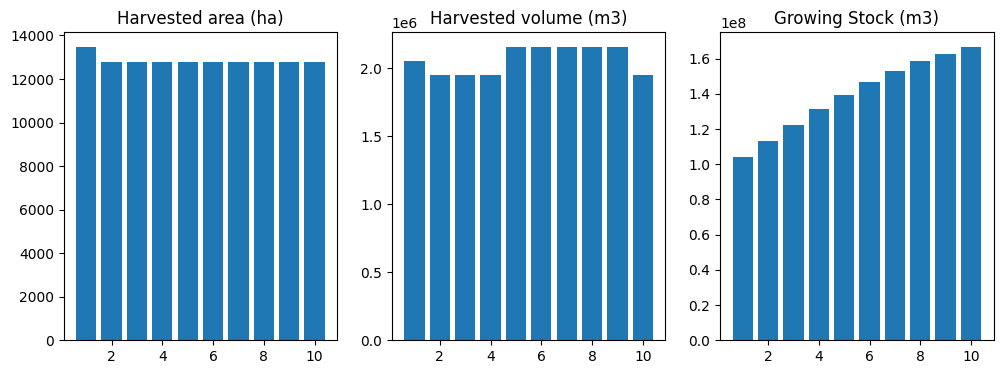

In [14]:
fig, df, problem = run_scenario(fm, 'base-cgen_gs_ha_100') 

In [15]:
# fig, df, problem = run_scenario(fm, 'base-cgen_ha_0%')

In [16]:
# run_scenario(fm, 'base-cgen_hv')

In [17]:
# run_scenario(fm, 'base-cgen_gs')